<a href="https://colab.research.google.com/github/vijayalakshmisatya/Mammogram-Breast-Cancer-detection/blob/main/Mammogram_breast_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import re
from glob import glob
import pandas as pd
import scipy as sp
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.ndimage as ndi
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/mias-mammography

 98% 306M/312M [00:06<00:00, 76.3MB/s]
100% 312M/312M [00:06<00:00, 51.3MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('mias-mammography.zip', 'r') as zip_ref:
    zip_ref.extractall('mias')

In [ ]:
from collections import Counter
!pip install preprocessing
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split


import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.6/349.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.3 MB/s eta 0:00:00
  Created wheel for nltk: filename=nltk-3.2.4-py3-none-any.whl size=1367708 sha256=12d7cd59c1e1ecbeec9c7c3ef4b5f49d535c9861c4d3bb35733ad9282ff3a3c1
  Stored in directory: /root/.cache/pip/wheels/0e/8c/42/bcd0934b61ecf4cef964ccc9881888cca0841ec72266e99de1
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [ ]:
base_h5 = os.path.join('..', 'input', '/content/mias/all-mias', '/content/mias/all_mias_scans.h5')
tif_dir = 'tiffs'
os.makedirs(tif_dir, exist_ok=True)
with h5py.File(base_h5, 'r') as f:
    mammo_df = pd.DataFrame(
        {k: v if len(v.shape)==1 else [sub_v for sub_v in v]
         for k,v in f.items()}
    )
for k in mammo_df.columns:
    if isinstance(mammo_df[k].values[0], bytes):
        mammo_df[k] = mammo_df[k].map(lambda x: x.decode())

# save data to disk as TIFF images
from skimage.io import imsave

def to_path(c_row):
    out_path = os.path.join(tif_dir, '%s.tif' % c_row['REFNUM'])
    imsave(out_path, c_row['scan'])
    return out_path

mammo_df['scan'] = mammo_df.apply(to_path, 1)
def read_image():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i < 9:
            image_name = 'mdb00' + str(i + 1)
        elif i < 99:
            image_name = 'mdb0' + str(i + 1)
        else:
            image_name = 'mdb' + str(i + 1)
        image_address = os.path.join(tif_dir, image_name + '.tif')
        img = cv2.imread(image_address, 1)
        img = cv2.resize(img, (224, 224))
        rows, cols, color = img.shape
        info[image_name] = {}
        for angle in range(0, no_angles, 8):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle] = img_rotated
    return info
no_angles = 360
def read_label():
    print("Reading labels")
    filename = os.path.join(tif_dir, '/content/mias/Info.txt')
    text_all = open(filename).read()
    lines = text_all.split('\n')
    info = {}
    for line in lines:
        words = line.split(' ')
        if len(words) > 3:
            if words[3] == 'B':
                info[words[0]] = {}
                for angle in range(0, no_angles, 8):
                    info[words[0]][angle] = 0
            elif words[3] == 'M':
                info[words[0]] = {}
                for angle in range(0, no_angles, 8):
                    info[words[0]][angle] = 1
    return info

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
lable_info=read_label()
image_info=read_image()
#print(image_info[1][0])
ids=lable_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
if 'Truth-Data:' in lable_info:
    del lable_info['Truth-Data:']

#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2021,shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, random_state=2021,shuffle=True)
# cancer_prediction_cnn(x_train, y_train, x_test, y_test)

Reading labels
Reading images


INCEPTION V3


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

(224, 224, 3)
87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 batch_normalization_94 (Bat  (None, 51200)            204800    
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 batch_normalization_95 (Bat  (None, 256)  

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [ ]:
def save_dictionary(path,data):
    print('saving catalog...')
    #open('u.item', encoding="utf-8")
    import json
    with open(path,'w') as outfile:
        json.dump(str(data), fp=outfile)
      # save to file:
    print(' catalog saved')

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=4, batch_size=128,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/4
25/25 [==============================] - 505s 20s/step - loss: 0.2165 - accuracy: 0.9144 - val_loss: 0.5293 - val_accuracy: 0.7807
Epoch 2/4
25/25 [==============================] - 503s 20s/step - loss: 0.1575 - accuracy: 0.9421 - val_loss: 0.5705 - val_accuracy: 0.7897
Epoch 3/4
25/25 [==============================] - 501s 20s/step - loss: 0.1289 - accuracy: 0.9531 - val_loss: 0.5448 - val_accuracy: 0.8271
Epoch 4/4
25/25 [==============================] - 98s 4s/step - loss: 0.5404 - accuracy: 0.7954
Test_loss_value = 0.5404154658317566
test_accuracy = 0.7953668236732483
saving catalog...
 catalog saved


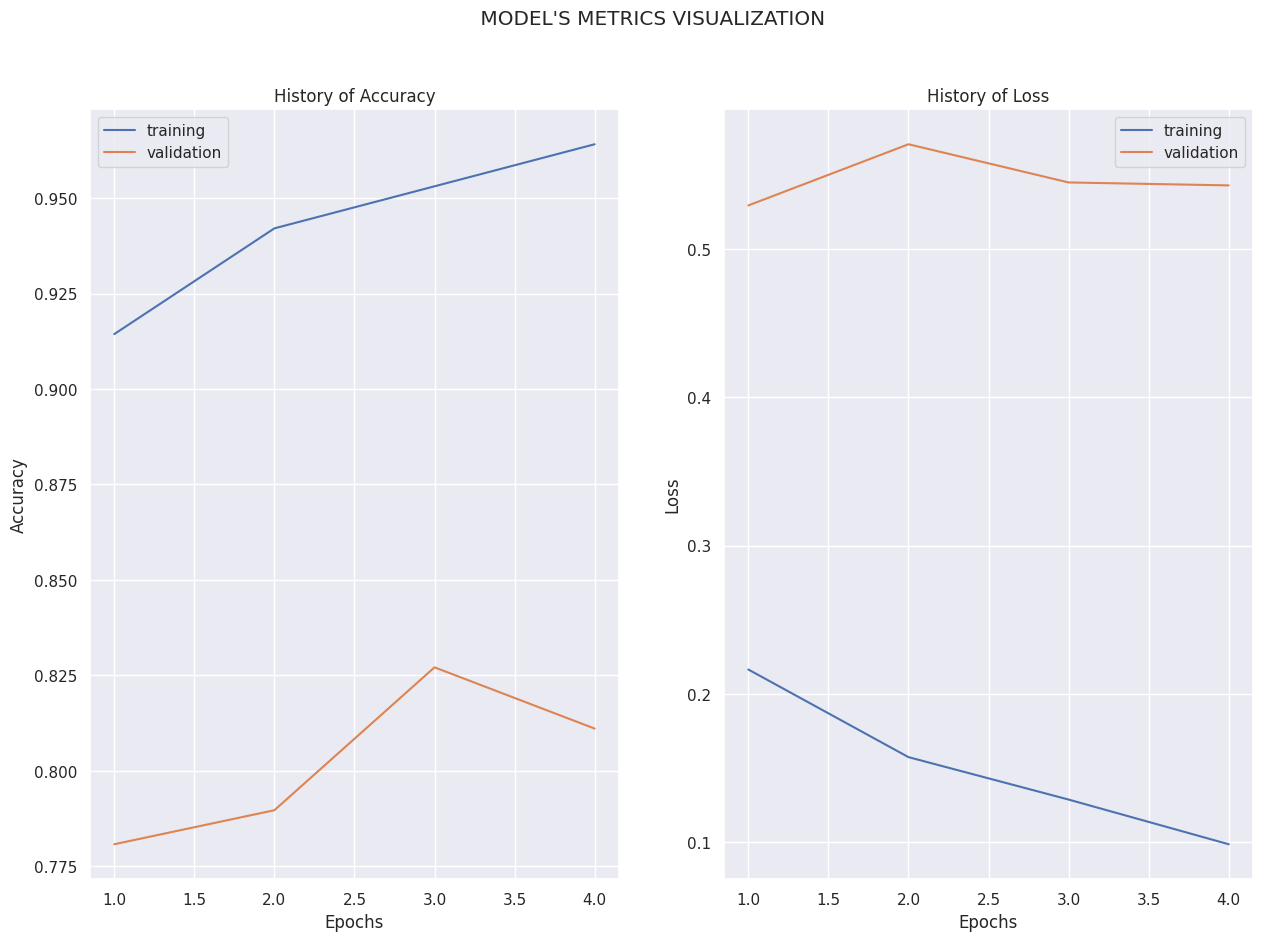

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

MOBILENET


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

(224, 224, 3)
17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 batch_normalization_97 (Bat  (None, 50176)            200704    
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 128)               6422656   
                                         

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=8,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=6, batch_size=128,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/6
25/25 [==============================] - 223s 9s/step - loss: 0.6901 - accuracy: 0.5877 - val_loss: 1.1017 - val_accuracy: 0.6275
Epoch 2/6
25/25 [==============================] - 214s 9s/step - loss: 0.4241 - accuracy: 0.8124 - val_loss: 0.6605 - val_accuracy: 0.7005
Epoch 3/6
25/25 [==============================] - 211s 9s/step - loss: 0.2472 - accuracy: 0.9175 - val_loss: 0.5177 - val_accuracy: 0.7576
Epoch 4/6
25/25 [==============================] - 207s 8s/step - loss: 0.1281 - accuracy: 0.9654 - val_loss: 0.4109 - val_accuracy: 0.8111
Epoch 5/6
25/25 [==============================] - 212s 9s/step - loss: 0.0740 - accuracy: 0.9811 - val_loss: 0.3464 - val_accuracy: 0.8503
Epoch 6/6
25/25 [==============================] - 38s 1s/step - loss: 0.2818 - accuracy: 0.8906
Test_loss_value = 0.2817939221858978
test_accuracy = 0.8906049132347107
saving catalog...
 catalog saved


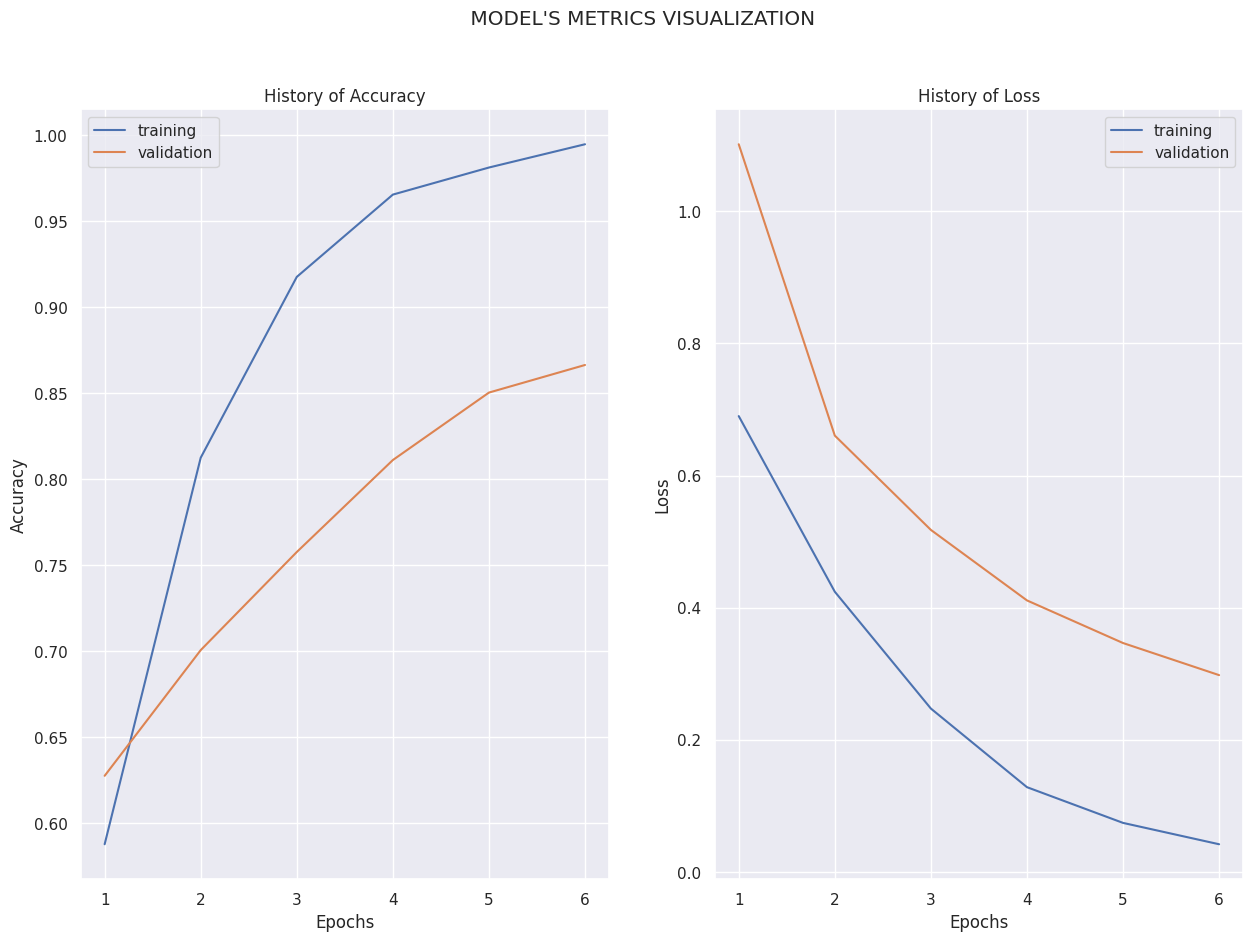

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

RESNET

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = ResNet101(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

(224, 224, 3)
171446536/171446536 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Batc  (None, 256)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=8,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=4, batch_size=128,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)


Epoch 1/6
30/30 [==============================] - 2266s 74s/step - loss: 0.7062 - accuracy: 0.5918 - val_loss: 0.9714 - val_accuracy: 0.6515
Epoch 2/6
30/30 [==============================] - 1781s 59s/step - loss: 0.4272 - accuracy: 0.8066 - val_loss: 0.5830 - val_accuracy: 0.7985
Epoch 3/6
30/30 [==============================] - 1719s 58s/step - loss: 0.1825 - accuracy: 0.9315 - val_loss: 0.3373 - val_accuracy: 0.8712
Epoch 4/6
30/30 [==============================] - 1730s 58s/step - loss: 0.0840 - accuracy: 0.9738 - val_loss: 0.1986 - val_accuracy: 0.9273
Epoch 5/6
30/30 [==============================] - 1682s 56s/step - loss: 0.0382 - accuracy: 0.9909 - val_loss: 0.1566 - val_accuracy: 0.9409
Epoch 6/6
117/117 [==============================] - 1293s 11s/step - loss: 0.0057 - accuracy: 0.9989
Training accuracy = 0.9989299178123474
21/21 [==============================] - 233s 11s/step - loss: 0.1194 - accuracy: 0.9621
Validation accuracy = 0.9621211886405945
25/25 [============

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=10, batch_size=128,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/10
20/25 [=======================>......] - ETA: 6:41 - loss: 0.6545 - accuracy: 0.6859

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_data=(x_valid,y_valid),shuffle=True, epochs=6, batch_size=128,callbacks=[es])
loss_value , accuracy = model.evaluate(x_train, y_train)
print('Training accuracy = ' + str(accuracy))
loss_value , accuracy = model.evaluate(x_valid, y_valid)
print('Validation accuracy = ' + str(accuracy))
loss_value , accuracy = model.evaluate(x_test, y_test)
print('Test accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
target=["B","M"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

  polar transformation

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

def centroid(img, lcc=False):
  if lcc:
    img = img.astype(np.uint8)
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=4)
    sizes = stats[:, -1]
    if len(sizes) > 2:
      max_label = 1
      max_size = sizes[1]

      for i in range(2, nb_components):
          if sizes[i] > max_size:
              max_label = i
              max_size = sizes[i]

      img2 = np.zeros(output.shape)
      img2[output == max_label] = 255
      img = img2

  if len(img.shape) > 2:
    M = cv.moments(img[:,:,1])
  else:
    M = cv.moments(img)

  if M["m00"] == 0:
    return (img.shape[0] // 2, img.shape[1] // 2)

  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  return (cX, cY)

def to_polar(input_img, center):
  input_img = input_img.astype(np.float32)
  value = np.sqrt(((input_img.shape[0]/2.0)**2.0)+((input_img.shape[1]/2.0)**2.0))
  polar_image = cv.linearPolar(input_img, center, value, cv.WARP_FILL_OUTLIERS)
  polar_image = cv.rotate(polar_image, cv.ROTATE_90_COUNTERCLOCKWISE)
  return polar_image

def to_cart(input_img, center):
  input_img = input_img.astype(np.float32)
  input_img = cv.rotate(input_img, cv.ROTATE_90_CLOCKWISE)
  value = np.sqrt(((input_img.shape[1]/2.0)**2.0)+((input_img.shape[0]/2.0)**2.0))

  polar_image = cv.linearPolar(input_img, center, value, cv.WARP_FILL_OUTLIERS + cv.WARP_INVERSE_MAP)
  polar_image = polar_image.astype(np.uint8)
  return polar_image

if __name__ == "__main__":
  input_dir = '/content/tiffs'
  output_dir = '/content/P'
  os.makedirs(output_dir, exist_ok=True)
  for filename in os.listdir(input_dir):
    if filename.endswith('.tif'):
      image = cv.imread(os.path.join(input_dir, filename))

      center = centroid(image)

      polar = to_polar(image, center)

      #cart = to_cart(polar, center)

      cv.imwrite(os.path.join(output_dir, os.path.splitext(filename)[0] + '.png'), polar)



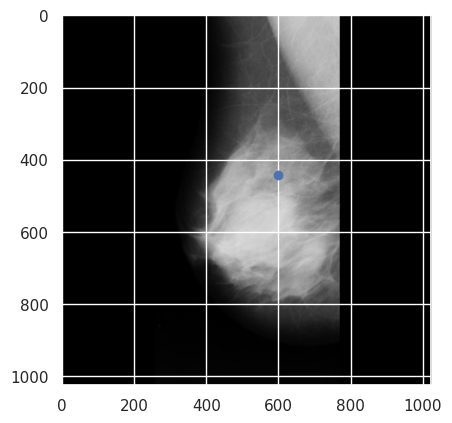

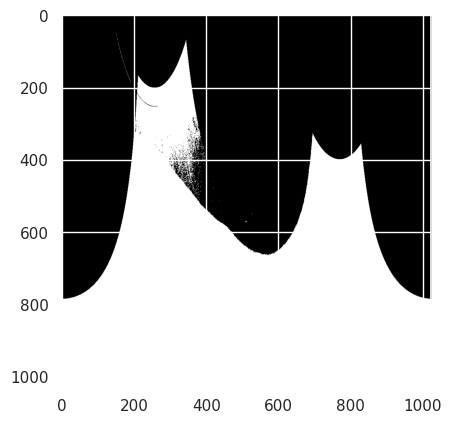

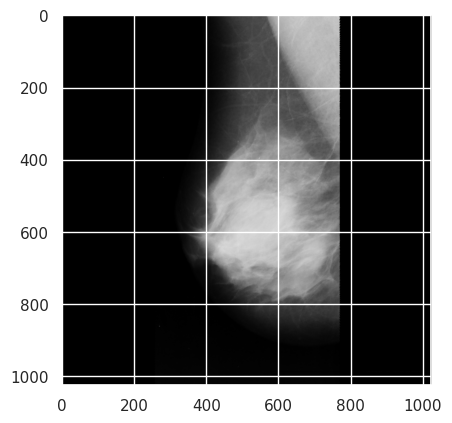

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

def centroid(img, lcc=False):
  if lcc:
    img = img.astype(np.uint8)
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=4)
    sizes = stats[:, -1]
    if len(sizes) > 2:
      max_label = 1
      max_size = sizes[1]

      for i in range(2, nb_components):
          if sizes[i] > max_size:
              max_label = i
              max_size = sizes[i]

      img2 = np.zeros(output.shape)
      img2[output == max_label] = 255
      img = img2

  if len(img.shape) > 2:
    M = cv.moments(img[:,:,1])
  else:
    M = cv.moments(img)

  if M["m00"] == 0:
    return (img.shape[0] // 2, img.shape[1] // 2)

  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  return (cX, cY)

def to_polar(input_img, center):
  input_img = input_img.astype(np.float32)
  value = np.sqrt(((input_img.shape[0]/2.0)**2.0)+((input_img.shape[1]/2.0)**2.0))
  polar_image = cv.linearPolar(input_img, center, value, cv.WARP_FILL_OUTLIERS)
  polar_image = cv.rotate(polar_image, cv.ROTATE_90_COUNTERCLOCKWISE)
  return polar_image

def to_cart(input_img, center):
  input_img = input_img.astype(np.float32)
  input_img = cv.rotate(input_img, cv.ROTATE_90_CLOCKWISE)
  value = np.sqrt(((input_img.shape[1]/2.0)**2.0)+((input_img.shape[0]/2.0)**2.0))
  polar_image = cv.linearPolar(input_img, center, value, cv.WARP_FILL_OUTLIERS + cv.WARP_INVERSE_MAP)
  polar_image = polar_image.astype(np.uint8)
  return polar_image

if __name__ == "__main__":
  image = cv.imread('/content/tiffs/mdb001.tif')
  plt.imshow(image)

  center = centroid(image)
  plt.scatter(center[0], center[1])
  plt.show()

  polar = to_polar(image, center)
  plt.imshow(polar)
  plt.show()

  cart = to_cart(polar, center)
  plt.imshow(cart)
  plt.show()

unet++



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
input_shape = (256, 256, 3)

def build_model(input_shape):
    inputs = Input(input_shape)

    # Encoder Path
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Center Path
    center = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    center = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(center)
    drop5 = tf.keras.layers.Dropout(0.5)(center)

    # Decoder Path
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4, up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = outputs)

    return model
import os
import numpy as np
from PIL import Image
from PIL import Image, TiffImagePlugin
# Load the model
model = build_model(input_shape)
TiffImagePlugin.READ_LIBTIFF = True
# Load the images from the directory
dir_path = "/content/P"
#dir_path = "/content/polo"




# Load all the images in the directory
file_list = os.listdir(dir_path)
images = []
for file_name in file_list:
    image_path = os.path.join(dir_path, file_name)
    image = Image.open(image_path)
    image = image.convert("RGB")
    image = image.resize(input_shape[:2])
    image = np.asarray(image) / 255.0
    images.append(image)
images = np.asarray(images)
# Set true labels
import numpy as np

# read the Info.txt file
with open('/content/mias/Info.txt', 'r') as f:
    info = f.readlines()

# extract the labels from the file
labels = []
for row in info:
    label = row.split(' ')[-2]
    if label == 'B':
        labels.append(0)
    else:
        labels.append(1)

# convert labels to numpy array
true_labels = np.array(labels)


# Predict the labels of the images
predictions = model.predict(images)

# Convert probabilities to binary labels
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Calculate precision, recall, and F1-score
# Predict the labels of the images
predictions = model.predict(images)

# Compute the accuracy
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)
accuracy = np.mean(predicted_labels == true_labels)
print(f'Binary accuracy: {accuracy}')








11/11 [==============================] - 726s 65s/step
Binary accuracy: 0.9995992909307065


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
input_shape = (256, 256, 3)

def build_model(input_shape):
    inputs = Input(input_shape)

    # Encoder Path
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Center Path
    center = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    center = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(center)
    drop5 = tf.keras.layers.Dropout(0.5)(center)

    # Decoder Path
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4, up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = outputs)

    return model
import os
import numpy as np
from PIL import Image
from PIL import Image, TiffImagePlugin
# Load the model
model = build_model(input_shape)
TiffImagePlugin.READ_LIBTIFF = True
# Load the images from the directory
dir_path = "/content/P"
#dir_path = "/content/PPP"




# Load all the images in the directory
file_list = os.listdir(dir_path)
images = []
for file_name in file_list:
    image_path = os.path.join(dir_path, file_name)
    image = Image.open(image_path)
    image = image.convert("RGB")
    image = image.resize(input_shape[:2])
    image = np.asarray(image) / 255.0
    images.append(image)
images = np.asarray(images)
# Set true labels
import numpy as np

# read the Info.txt file
with open('/content/mias/Info.txt', 'r') as f:
    info = f.readlines()


import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
true_labels = np.array(labels)
true_labels_bin = np.where(true_labels == 0.5, 0, true_labels).astype(int) # convert to binary values

labels = []
for row in info:
    label = row.split(' ')[-2]
    if label == 'B':
        labels.append(0)
    elif label == 'M':
        labels.append(1)
    else:
        labels.append(0.5) # assign a label of 0.5 to unknown labels

# convert labels to numpy array
true_labels = np.array(labels)
true_labels_bin = np.where(true_labels == 0.5, 0, true_labels).astype(int) # convert to binary values
# filter out unknown labels
mask = true_labels_bin != 0.5
true_labels_bin = true_labels_bin[mask]
threshold = 0.5
predictions = model.predict(images)
predicted_labels = (predictions > threshold).astype(int)


#predicted_labels = predicted_labels[mask]

# Compute the confusion matrix
cm = confusion_matrix(true_labels_bin, predicted_labels)
# Calculate precision, recall, and F1-score
precision = precision_score(true_labels_bin[:len(predicted_labels)], predicted_labels)
recall = recall_score(true_labels_bin[:len(predicted_labels)], predicted_labels)
f1 = f1_score(true_labels_bin[:len(predicted_labels)], predicted_labels)


# Convert probabilities to binary labels


# Calculate precision, recall, and F1-score
# Predict the labels of the images


# Compute the accuracy
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)
accuracy = np.mean(predicted_labels == true_labels)
print(f'Binary accuracy: {accuracy}')
print(f'Confusion matrix:\n{cm}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Sensitivity: {sensitivity:.4f}')









In [ ]:
# extract the labels from the file
labels = []
for row in info:
    label = row.split(' ')[-2]
    if label == 'B':
        labels.append(0)
    elif label == 'M':
        labels.append(1)


# convert labels to numpy array
true_labels_bin = np.array(labels)



# convert true_labels to binary values
true_labels_bin = (true_labels == 1).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(true_labels_bin[:len(predicted_labels)], predicted_labels)

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels_bin[:len(predicted_labels)], predicted_labels)
recall = recall_score(true_labels_bin[:len(predicted_labels)], predicted_labels)
f1 = f1_score(true_labels_bin[:len(predicted_labels)], predicted_labels)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')




ValueError: ignored

unet

In [ ]:


# Build U-Net model
from keras.layers.core import RepeatVector
from keras.layers import Conv2DTranspose

def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    # Join features information in the depthest layer



    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)



    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs = inputs, outputs = outputs)

    return model
import os
import numpy as np
from PIL import Image
from PIL import Image, TiffImagePlugin
# Load the model
model = build_model(input_shape)
TiffImagePlugin.READ_LIBTIFF = True
# Load the images from the directory
dir_path = "/content/polar transformed images"
#dir_path = "/content/polo"




# Load all the images in the directory
file_list = os.listdir(dir_path)
images = []
for file_name in file_list:
    image_path = os.path.join(dir_path, file_name)
    image = Image.open(image_path)
    image = image.convert("RGB")
    image = image.resize(input_shape[:2])
    image = np.asarray(image) / 255.0
    images.append(image)
images = np.asarray(images)
# Set true labels
import numpy as np

# read the Info.txt file
with open('/content/mias/Info.txt', 'r') as f:
    info = f.readlines()

# extract the labels from the file
labels = []
for row in info:
    label = row.split(' ')[-2]
    if label == 'B':
        labels.append(0)
    else:
        labels.append(1)

# convert labels to numpy array
true_labels = np.array(labels)


# Predict the labels of the images
predictions = model.predict(images)

# Convert probabilities to binary labels
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Calculate precision, recall, and F1-score
# Predict the labels of the images
predictions = model.predict(images)

# Compute the accuracy
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)
accuracy = np.mean(predicted_labels == true_labels)
print(f'Binary accuracy: {accuracy}')




resnet with poalr transformation


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil

# Directory path of the polar transformation images
dir_path = "/content/P"

# Split the data into train and validation sets
file_list = os.listdir(dir_path)
train_files, valid_files = train_test_split(file_list, test_size=0.2, random_state=42)

# Create directories for train and validation data
train_dir = "/path/to/train"
valid_dir = "/path/to/validation"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Move the train files to the train directory
for file_name in train_files:
    src = os.path.join(dir_path, file_name)
    dst = os.path.join(train_dir, file_name)
    shutil.move(src, dst)

# Move the validation files to the validation directory
for file_name in valid_files:
    src = os.path.join(dir_path, file_name)
    dst = os.path.join(valid_dir, file_name)
    shutil.move(src, dst)




In [ ]:
# Define input shape for polar images
input_shape = (224, 224, 3)

# Create an instance of the ResNet50 model (without the top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the weights of the pre-trained ResNet model
for layer in resnet_model.layers:
    layer.trainable = False

# Create a new top layer for the ResNet model
flatten = Flatten()(resnet_model.output)
output = Dense(1, activation='sigmoid')(flatten)

# Create the final model
model = Model(inputs=resnet_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Specify the batch size and number of training/validation steps per epoch
batch_size = 32
train_steps_per_epoch = len(train_files) // batch_size
valid_steps_per_epoch = len(valid_files) // batch_size

# Use an ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import MaxPooling2D

input_shape = (256, 256, 3)

def build_resnet(input_shape):
    inputs = Input(input_shape)

    # Initial convolution block
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = residual_block(x, 512, strides=2)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    # Global average pooling and output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

def residual_block(inputs, filters, strides=1):
    x = Conv2D(filters, 3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    if strides == 1:
        x = Add()([x, inputs])
    else:
        shortcut = Conv2D(filters, 1, strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
        x = Add()([x, shortcut])

    x = Activation('relu')(x)

    return x

# Build the ResNet model
model = build_resnet(input_shape)

import os
import numpy as np
from PIL import Image

# Set the directory path
dir_path = "/content/P"
# Load all the images in the directory
file_list = os.listdir(dir_path)
images = []
for file_name in file_list:
    image_path = os.path.join(dir_path, file_name)
    image = Image.open(image_path)
    image = image.convert("RGB")
    image = image.resize(input_shape[:2])
    image = np.asarray(image) / 255.0
    images.append(image)
images = np.asarray(images)
# Set true labels
import numpy as np

# read the Info.txt file
with open('/content/mias/Info.txt', 'r') as f:
    info = f.readlines()

# extract the labels from the file
labels = []
for row in info:
    label = row.split(' ')[-2]
    if label == 'B':
        labels.append(0)
    else:
        labels.append(1)

# convert labels to numpy array
true_labels = np.array(labels)


# Predict the labels of the images
predictions = model.predict(images)

# Convert probabilities to binary labels
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Calculate precision, recall, and F1-score
# Predict the labels of the images
predictions = model.predict(images)

# Compute the accuracy
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)
accuracy = np.mean(predicted_labels == true_labels)
print(f'Binary accuracy: {accuracy}')








11/11 [==============================] - 54s 5s/step
Binary accuracy: 1.0
